대기시간: 접안(배를 육지에 대는 것)전에 선박이 해상에 정박(해상에 닻을 바다 밑바닥에 내려놓고 운항을 멈추는 것)하는 시간

산출된 항차(선박의 여정)데이터를 활용하여 항만 內 선박의 대기 시간을 예측

# 1. 라이브러리 호출

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import lightgbm as lgb
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor

import bisect
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

import time

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
import os
if os.getcwd() != '/content/drive/My Drive':
    os.chdir('./drive/My Drive')

Mounted at /content/drive/


In [3]:
!pwd

/content/drive/My Drive


# 2. train, test data load

In [4]:
train = pd.read_csv('./HD/Data/train.csv')
test = pd.read_csv('./HD/Data/test.csv')

In [5]:
print(len(train), len(test))

367441 244989


ARI_CO: 도착항의 소속국가(도착항 앞 2글자)
- 'CN', 'JP', 'RU', 'AU', 'SG', 'ZA', 'KR', 'TW', 'TT', 'ID', 'BR', 'QA', 'LV', 'MZ', 'US', 'IN', 'UA', 'CA', 'MY', 'PE', 'VN', 'FI', 'CL', 'VE', 'PH'

ARI_PO: 도착항의 항구명(도착항 뒤 글자)
- 'EKP8', 'EUC8', 'NGG6', 'TMR7', 'NNC2', 'ZAG4', 'MIA8', 'QYY1', 'WHH4', 'YDP4', 'KSF1', 'VYJ1', 'GIW5', 'SPG1', 'CXL1', 'BGD2', 'FCD5', 'QQW1', 'JWI3', 'HGH2', 'IVU2', 'URE2', 'WEY7', 'LXJ7', 'IEW6', 'UVK6', 'MMW5', 'JEN5', 'YRT6', 'VXM8', 'HYG5', 'NCU8', 'JTD1', 'VFD8', 'AZU6', 'AIB7', 'KIU2', 'TDA5', 'WXQ2', 'MCG4', 'QEA4', 'OZD2', 'PDL4', 'UIR7', 'QGN3', 'UJM2', 'TMW2', 'WAF5', 'NQO4', 'CEI5', 'DMD4', 'EVL6', 'XVZ3', 'JER7', 'QTU5', 'XIU1', 'EVX2', 'BAZ5', 'QGL7', 'PPM2', 'RKA2', 'PEL6', 'LHD1', 'URD4', 'TXO3', 'BGX4', 'FFM2', 'YFK5', 'SLZ5', 'QRN3', 'EIA2', 'FAV3', 'OKM4', 'OBZ3', 'CSP6', 'PAF4', 'TBL3', 'JGL5', 'TYY2', 'XGX5', 'UEW5', 'GRQ5', 'HYV6', 'REJ1', 'PUF3', 'SXD2', 'FTQ1', 'PBQ1', 'JDG8', 'MOC5', 'DEJ2', 'XEO4', 'GQJ7', 'EFG4', 'OOV8', 'UPI6', 'JEA6', 'QXE2', 'DIN2', 'ZME5', 'ONW1', 'XZF6', 'RGT8'
       
SHIP_TYPE_CATEGORY: 선종 통합 바탕으로 5대 선종으로 분류
- 'Bulk', 'Container', 'Cargo', 'Tanker'

DIST: 정박지(ber_port)와 접안지 사이의 거리

ATA: anc_port에 도착한 시점의 utc. 실제 정박 시각(Actual Time of Arrival)

ID: 선박식별 일련번호

BREADTH: 선박의 폭

BUILT: 선박의 연령

DEADWEIGHT: 선박의 재화중량톤수

DEPTH: 선박의 깊이

DRAUGHT: 흘수 높이

GT: 용적톤수(Gross Tonnage)값

LENGTH: 선박의 길이

SHIPMANAGER: 선박 소유주

FLAG: 선박의 국적

U_WIND: 풍향 u벡터

V_WIND: 풍향 v벡터

AIR_TEMPERATURE: 기온

BN: 보퍼트 풍력 계급

ATA_LT: anc_port에 도착한 시점의 현지 정박 시각(Local Time of Arrival)(단위 : H)

DUBAI: 해당일의 두바이유 값

BRENT: 해당일의 브렌트유 값

WTI: 해당일의 WTI 값

BDI_ADJ: 조정된 벌크운임지수

PORT_SIZE: 접안지 폴리곤 영역의 크기

#### <span style="color:blue"> target </span>
CI_HOUR: 대기시간

In [6]:
train.head()

,SAMPLE_ID,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,...,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,DUBAI,BRENT,WTI,BDI_ADJ,PORT_SIZE,CI_HOUR
0,TRAIN_000000,CN,EKP8,Bulk,30.736578,2020-10-15 4:03,Z517571,30.0,28,73100,...,3.77,15.9,2.730798,12,42.01,43.16,40.96,1407.668330,0.001660,3.048333
1,TRAIN_000001,CN,EUC8,Container,63.220425,2019-09-17 2:55,U467618,30.0,15,37900,...,-6.72,24.5,4.289058,10,67.53,64.55,59.34,2089.046774,0.001614,17.138611
2,TRAIN_000002,CN,NGG6,Container,90.427421,2019-02-23 6:43,V378315,50.0,7,115000,...,0.00,9.4,0.000000,14,65.30,66.39,56.94,603.193047,0.001743,98.827500
3,TRAIN_000003,JP,TMR7,Cargo,0.000000,2020-09-18 22:06,B726632,10.0,33,1490,...,-7.31,22.1,4.693735,7,43.02,43.15,41.11,1169.853455,0.000069,0.000000
4,TRAIN_000004,RU,NNC2,Container,8.813725,2022-08-13 12:57,D215135,30.0,10,27600,...,2.31,22.8,2.345875,14,90.45,93.65,88.11,1107.944894,0.000197,96.030556


In [7]:
# target column 없음
test.head()

,SAMPLE_ID,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,...,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,DUBAI,BRENT,WTI,BDI_ADJ,PORT_SIZE
0,TEST_000000,JP,HYG5,Tanker,9.508139,2022-08-27 8:29,R721438,20.0,9,5510,...,0.18,0.63,26.8,0.850060,17,97.88,96.49,89.55,766.977634,0.000256
1,TEST_000001,SG,GIW5,Container,24.186684,2022-03-27 20:57,G185231,40.0,14,109000,...,-0.81,-0.77,27.5,1.213528,4,98.14,104.64,100.60,1655.006791,0.002615
2,TEST_000002,TW,EKP8,Cargo,0.000000,2023-01-18 2:06,P862781,20.0,14,13700,...,-6.25,-12.57,16.1,6.557436,10,83.70,84.98,79.48,682.595117,0.000427
3,TEST_000003,JP,HYG5,Bulk,0.000000,2016-08-02 0:59,B415437,10.0,18,2840,...,NaN,NaN,NaN,NaN,9,38.85,41.80,39.51,629.378100,0.000256
4,TEST_000004,SG,GIW5,Container,19.834186,2023-01-24 0:27,J412562,30.0,23,30700,...,1.58,-4.47,23.8,3.180123,8,83.88,86.13,80.13,563.101921,0.002615


# 3. data pre processing

## 3.1 이상치 처리

In [8]:
# DIST가 0이면 CI_HOUR도 0이어야함 - 개념적으로
DIST_0 = train[train['DIST'] == 0]
CI_HOUR_NOT_0_idx = DIST_0.index[DIST_0['CI_HOUR'] != 0].tolist()
train.loc[CI_HOUR_NOT_0_idx, ['CI_HOUR']] = 0
train

,SAMPLE_ID,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,...,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,DUBAI,BRENT,WTI,BDI_ADJ,PORT_SIZE,CI_HOUR
0,TRAIN_000000,CN,EKP8,Bulk,30.736578,2020-10-15 4:03,Z517571,30.0,28,73100,...,3.77,15.9,2.730798,12,42.01,43.16,40.96,1407.668330,0.001660,3.048333
1,TRAIN_000001,CN,EUC8,Container,63.220425,2019-09-17 2:55,U467618,30.0,15,37900,...,-6.72,24.5,4.289058,10,67.53,64.55,59.34,2089.046774,0.001614,17.138611
2,TRAIN_000002,CN,NGG6,Container,90.427421,2019-02-23 6:43,V378315,50.0,7,115000,...,0.00,9.4,0.000000,14,65.30,66.39,56.94,603.193047,0.001743,98.827500
3,TRAIN_000003,JP,TMR7,Cargo,0.000000,2020-09-18 22:06,B726632,10.0,33,1490,...,-7.31,22.1,4.693735,7,43.02,43.15,41.11,1169.853455,0.000069,0.000000
4,TRAIN_000004,RU,NNC2,Container,8.813725,2022-08-13 12:57,D215135,30.0,10,27600,...,2.31,22.8,2.345875,14,90.45,93.65,88.11,1107.944894,0.000197,96.030556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367436,TRAIN_367436,CN,YRT6,Bulk,59.018184,2017-11-11 22:23,J661243,40.0,13,93200,...,NaN,NaN,NaN,6,61.25,62.21,55.70,1333.609109,0.000360,65.850000
367437,TRAIN_367437,JP,QYY1,Tanker,0.000000,2022-04-29 2:58,D847216,10.0,9,1280,...,0.87,17.1,1.028558,11,105.37,109.34,104.69,1955.103846,0.000552,0.000000
367438,TRAIN_367438,SG,GIW5,Container,1.768630,2022-07-14 7:58,Q635545,30.0,6,25000,...,3.36,31.7,2.557156,15,97.73,99.10,95.78,1601.291086,0.002615,0.997500
367439,TRAIN_367439,JP,TMR7,Cargo,0.000000,2020-12-22 10:07,N211282,10.0,8,2400,...,-2.44,10.8,3.055715,19,49.75,50.08,47.02,1191.353331,0.000069,0.000000


## 3.2 불필요한 데이터 삭제

In [9]:
train['ID']

0         Z517571
1         U467618
2         V378315
3         B726632
4         D215135
           ...   
367436    J661243
367437    D847216
367438    Q635545
367439    N211282
367440    V628821
Name: ID, Length: 367441, dtype: object

In [10]:
train.drop(columns=['SAMPLE_ID', 'ID'], inplace=True)
test.drop(columns=['SAMPLE_ID', 'ID'], inplace=True)

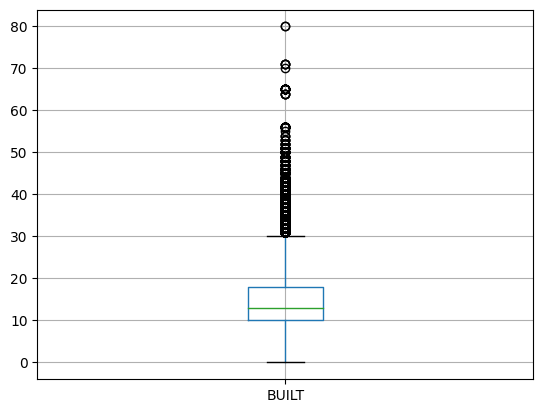

In [11]:
train.boxplot(column=['BUILT'])
plt.show()

In [12]:
# 선박의 평균 수명이 20~ 25인걸 생각하면 70이 넘는 건 뭘까나
train[train['BUILT'] > 50]

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,DUBAI,BRENT,WTI,BDI_ADJ,PORT_SIZE,CI_HOUR
2296,RU,FCD5,Tanker,0.000000,2022-01-31 14:57,10.0,55,1660,10.0,0.0,...,-6.08,-8.2,3.769792,16,88.39,91.21,88.15,1177.752016,0.000399,0.000000
4749,UA,PEL6,Cargo,2.775887,2021-09-12 21:36,10.0,65,1600,0.0,0.0,...,-3.92,17.8,2.810221,0,71.73,73.51,70.45,3565.822460,0.000117,6.961389
4830,CA,XIU1,Bulk,3.425041,2018-10-31 18:13,20.0,56,28500,10.0,10.0,...,NaN,NaN,NaN,15,71.67,72.83,63.14,1353.894324,0.000036,46.247778
7580,CN,EUC8,Container,58.673424,2018-06-24 14:24,30.0,52,38700,20.0,10.0,...,NaN,NaN,NaN,22,72.81,74.73,68.08,1246.446179,0.001614,15.188889
11607,RU,VXM8,Tanker,3.664640,2022-02-08 6:59,10.0,54,4410,10.0,10.0,...,6.18,1.1,3.948762,8,91.90,92.97,91.76,1555.391708,0.000145,211.998333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359140,KR,BGD2,Cargo,22.106699,2016-08-27 23:51,20.0,51,8440,10.0,10.0,...,NaN,NaN,NaN,8,42.98,45.45,43.16,692.937639,0.000244,119.195000
360318,UA,PEL6,Cargo,2.502781,2021-06-16 23:01,10.0,65,1600,0.0,0.0,...,-2.82,14.7,2.271614,2,72.35,73.08,71.04,2834.231990,0.000117,3.575556
360602,CA,XIU1,Bulk,1.841662,2017-11-06 18:17,20.0,71,18600,10.0,10.0,...,NaN,NaN,NaN,14,61.80,63.49,56.81,1410.493336,0.000036,48.583056
362108,KR,BGD2,Cargo,0.000000,2015-11-04 0:09,20.0,51,8440,10.0,10.0,...,NaN,NaN,NaN,9,45.45,48.58,46.32,647.896507,0.000244,0.000000


## 3.3 데이터 변환

In [13]:
#도착 국가와 항구 합치기
train['ARI_COPO'] = train['ARI_CO'] + '_' + train['ARI_PO']
test['ARI_COPO'] = test['ARI_CO'] + '_' + test['ARI_PO']

# ARI_CO, ARI_PO 컬럼 제거
train.drop(columns=['ARI_CO', 'ARI_PO'], inplace=True)
test.drop(columns=['ARI_CO', 'ARI_PO'], inplace=True)

In [14]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday # 요일(0-월, 1-화)

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

In [15]:
# hour, ATA_LT 어떻게 해결할지 더 생각해보기..........ㅇㄴㅁ러하기;ㄴㄷ

## 3.4 수치형, 범주형 데이터 변환

In [16]:
# Categorical 컬럼 인코딩
categorical_features = ['ARI_COPO', 'SHIP_TYPE_CATEGORY', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in categorical_features:
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

In [17]:
# 수치형 변수는 어떻게 처리?
#minmax? standard?

## 3.5 결측치 처리

In [18]:
# 결측치 확인
print(train.isnull().sum())
print('\n')
print(test.isnull().sum())

SHIP_TYPE_CATEGORY         0
DIST                       0
BREADTH                    1
BUILT                      0
DEADWEIGHT                 0
DEPTH                      1
DRAUGHT                    1
GT                         0
LENGTH                     1
SHIPMANAGER                0
FLAG                       0
U_WIND                153486
V_WIND                153486
AIR_TEMPERATURE       154365
BN                    153486
ATA_LT                     0
DUBAI                      0
BRENT                      0
WTI                        0
BDI_ADJ                    0
PORT_SIZE                  0
CI_HOUR                    0
ARI_COPO                   0
year                       0
month                      0
day                        0
hour                       0
minute                     0
weekday                    0
dtype: int64


SHIP_TYPE_CATEGORY         0
DIST                       0
BREADTH                    0
BUILT                      0
DEADWEIGHT                 0

In [19]:
# 결측치 처리
a = train[['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN']]
a

,U_WIND,V_WIND,AIR_TEMPERATURE,BN
0,0.14,3.77,15.9,2.730798
1,-3.16,-6.72,24.5,4.289058
2,0.00,0.00,9.4,0.000000
3,4.34,-7.31,22.1,4.693735
4,1.92,2.31,22.8,2.345875
...,...,...,...,...
367436,NaN,NaN,NaN,NaN
367437,-0.06,0.87,17.1,1.028558
367438,-0.63,3.36,31.7,2.557156
367439,3.74,-2.44,10.8,3.055715


In [20]:
# # 풍력으로 BN 구해보기
# wind_speed = (a['U_WIND'] ** 2 + a['V_WIND'] ** 2) ** (1/2)
# beaufort = (wind_speed / 0.836) ** (2/3)
# beaufort = round(beaufort, 9)

# a['BN'] = a['BN'].fillna('NaN')
# beaufort = beaufort.fillna('NaN')

# a['BN'] == beaufort

# a.index[a['BN'] != beaufort]
# # 직접 확인해보니까 같은거였음
# # 의미없었던 것임

In [21]:
# 같은 날은 풍량이 같을까해서 찾아봤는데 아니었음
# import datetime
# b = train[['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN', 'ATA']]
# b['ATA'] = pd.to_datetime(b['ATA'])
# b['ATA'] = b['ATA'].dt.date
# idx = b.index[b['ATA'] == datetime.date(2020, 10, 15)].tolist()
# b.loc[idx]

In [22]:
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)

# 4. 모델 학습 및 특성 중요도 확인

In [23]:
# 함수 정의
def train_and_evaluate(model, model_name, X_train, y_train):
    model.fit(X_train, y_train)

    # 변수 중요도
    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort() # index

    plt.figure(figsize=(10, len(X_train.columns)/2))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

## 4. 1 LGBM

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3652
[LightGBM] [Info] Number of data points in the train set: 367441, number of used features: 28
[LightGBM] [Info] Start training from score 61.869789


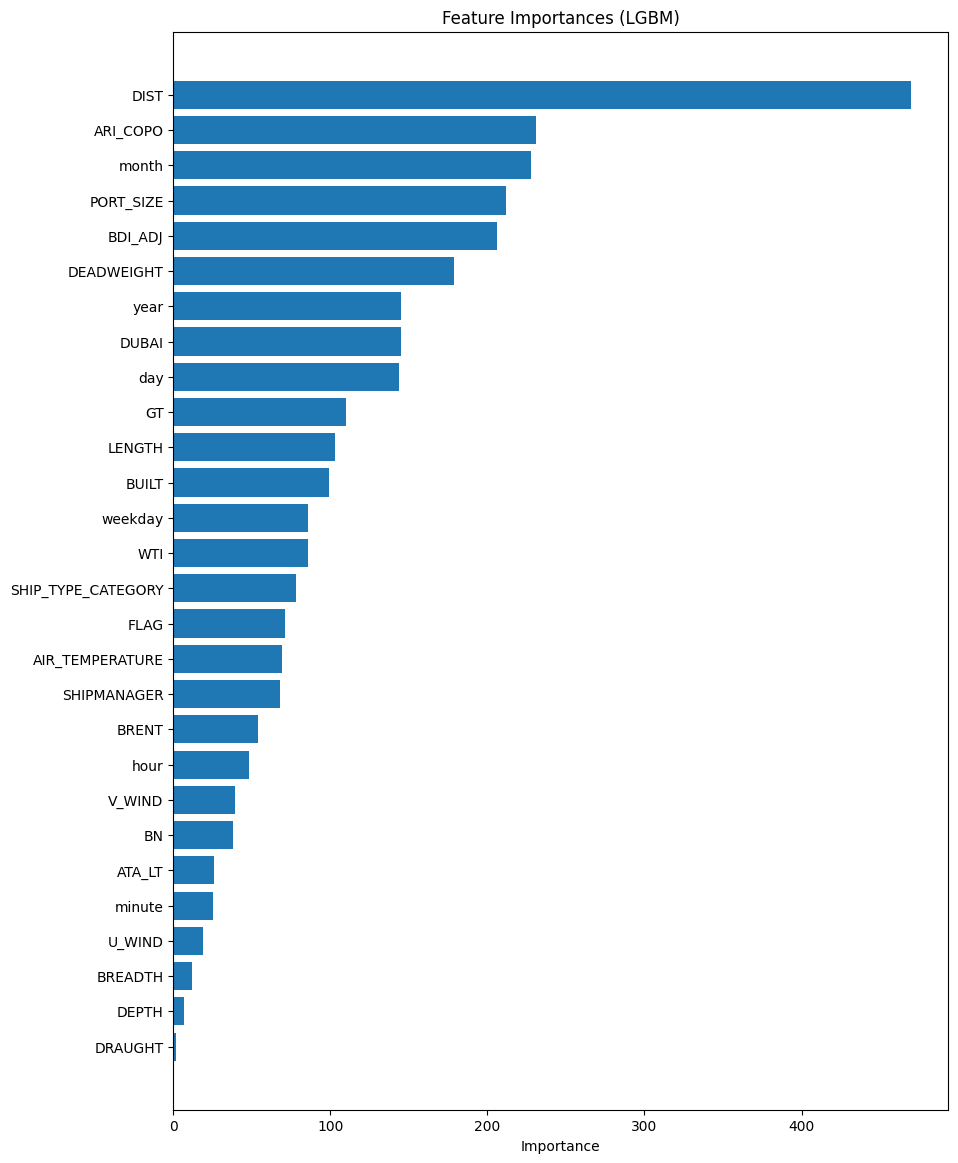

In [24]:
# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X_train, y_train)

In [25]:
# 특성 중요도로부터 Feature Selection
threshold = 85 # Your Threshold
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

print(low_importance_features)

Index(['SHIP_TYPE_CATEGORY', 'BREADTH', 'DEPTH', 'DRAUGHT', 'SHIPMANAGER',
       'FLAG', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN', 'ATA_LT', 'BRENT',
       'hour', 'minute'],
      dtype='object')


In [26]:
# import shap
# explainer = shap.TreeExplainer(lgbm_model) # Tree model Shap Value 확인 객체 지정
# shap_values = explainer.shap_values(X_train) # Shap Values 계산
# import skimage
# shap.initjs() # javascript 초기화 (graph 초기화)
# shap.force_plot(explainer.expected_value, shap_values[1,:], X_train.iloc[1,:])

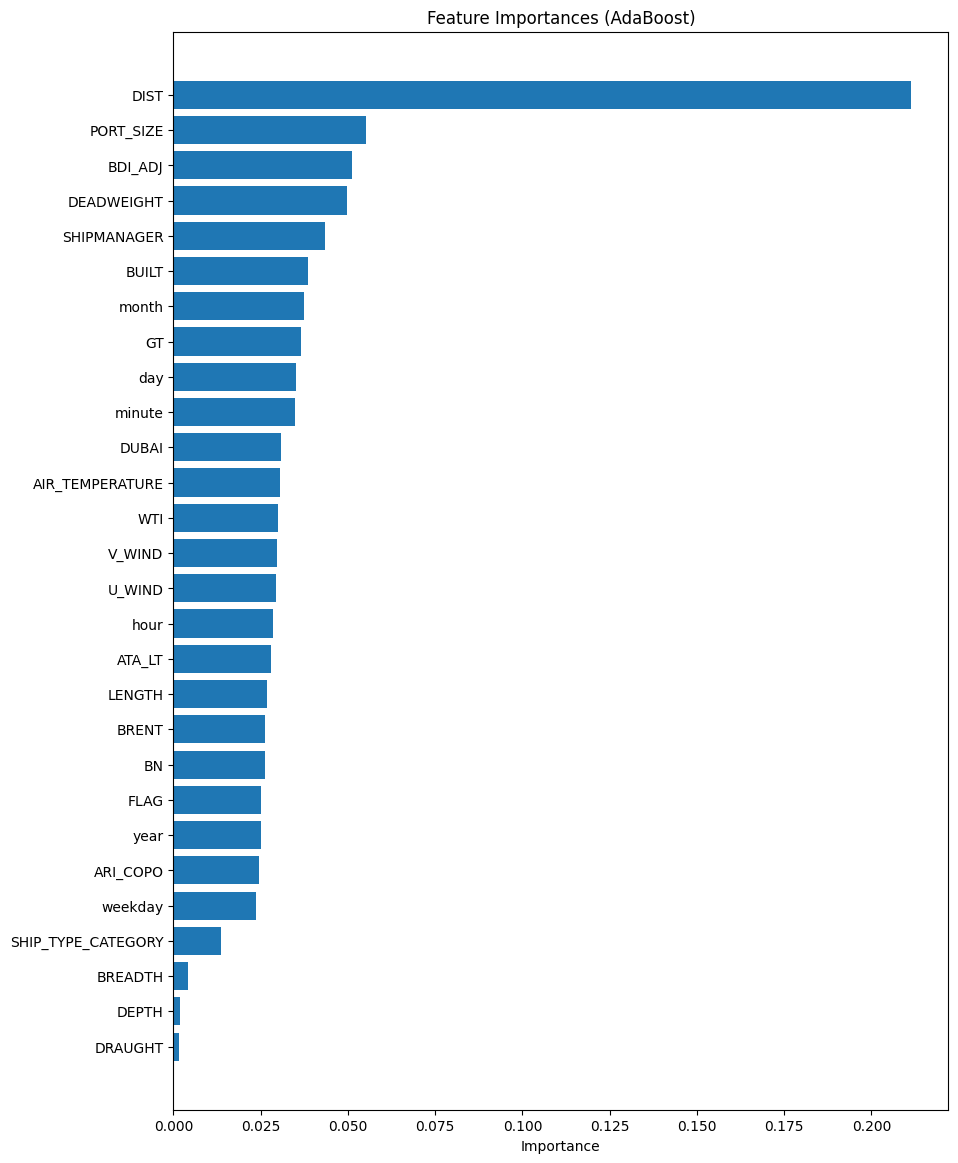

In [27]:
# Model Tune for AdaBoost
ada_model, ada_feature_importances = train_and_evaluate(RandomForestRegressor(), 'AdaBoost', X_train, y_train)

In [28]:
# 특성 중요도로부터 Feature Selection
threshold = 0.04 # Your Threshold
low_importance_features = X_train.columns[ada_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

print(low_importance_features)

Index(['SHIP_TYPE_CATEGORY', 'BREADTH', 'BUILT', 'DEPTH', 'DRAUGHT', 'GT',
       'LENGTH', 'FLAG', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN', 'ATA_LT',
       'DUBAI', 'BRENT', 'WTI', 'ARI_COPO', 'year', 'month', 'day', 'hour',
       'minute', 'weekday'],
      dtype='object')


# 5. K-Fold Model Fitting & Validation

In [29]:
lgbm = lgb.LGBMRegressor()

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in kf.split(X_train_reduced):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # 두 모델 모두 학습
    lgbm.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbm.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = lgbm.predict(X_test_reduced)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)

    ensemble_predictions.append(lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1122
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 5
[LightGBM] [Info] Start training from score 62.041608
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1122
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 5
[LightGBM] [Info] Start training from score 61.711543
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1122
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 5
[LightGBM] [Info

In [30]:
ada = RandomForestRegressor()

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in kf.split(X_train_reduced):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # 두 모델 모두 학습
    ada.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = ada.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    ada_pred = ada.predict(X_test_reduced)
    ada_pred = np.where(ada_pred < 0, 0, ada_pred)

    ensemble_predictions.append(ada_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Validation : MAE scores for each fold: [56.52324172573628, 57.32094823585613, 56.95985295417644, 57.03916299445163, 56.78208005320099]
Validation : MAE: 56.92505719268429


# 6. Submission

In [31]:
now = time.strftime('%Y-%m-%d %H:%M')

submit = pd.read_csv('./sample_submission.csv')
submit['CI_HOUR'] = final_predictions
submit.to_csv('./seo0928.csv', index=False)

FileNotFoundError: ignored

In [ ]:
'./submit' + now + '.csv'